In [1]:
import pandas as pd
import numpy as np

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly_express as px

import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
train_df = pd.read_csv('input/flight_delays_train.csv')
test_df = pd.read_csv('input/flight_delays_test.csv')


In [3]:
train_df.shape

(100000, 9)

In [4]:
train_df.head()

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y

In [16]:
## Here I collect all feature engineering

#Clean month, day of month and day of week
def feature_eng(df):
    df['Month'] = df['Month'].str[2:].astype('int')
    df['DayofMonth'] = df['DayofMonth'].str[2:].astype('int')
    df['DayOfWeek'] = df['DayOfWeek'].str[2:].astype('int')

    #Feature extraction
    df['weekend'] = [1 if ((day == 7) or (day== 6)) else 0 for day in df['DayOfWeek'] ]

    df['DayPart'] = ['morning' if (6<=np.floor(time/100)) and (np.floor(time/100) < 11) \
                           else 'noon' if (11<= np.floor(time/100)) and (np.floor(time/100) <17) \
                           else 'evening' if (17<= np.floor(time/100)) and (np.floor(time/100) <23)\
                           else 'night' for time in df['DepTime']]

    df['Seasons'] = df['Month'].map(lambda x:
                                                'winter' if x in (11,12,1) else
                                                'spring' if x in (2,3,4) else
                                                'summer' if x in (5,6,7) else
                                                'fall'                        
                                                )
    df['Semester'] = df['Month'].map(lambda x:
                                                 '1semester' if x in range(1,7) else
                                                 '2semseter')
    df['DepHour'] = df['DepTime'].map(lambda x: (x // 100) % 24)
    df.drop(['DepTime'], axis= 1)
    df['DepMinute'] = df['DepTime']%100
    df['DepHour'].replace(to_replace=[24,25], value=0, inplace=True)

    #Feature combining 
    df['Path'] = df['Origin'] + '-->' + df['Dest']

    #Feature transformation

    df['logDistance'] = np.log(df['Distance'])
    df['DepHour_sin'] = np.sin(2*np.pi*df['DepHour']/24)
    df['DepHour_cos'] = np.cos(2*np.pi*df['DepHour']/24)
    # this one has to be changed
    # здесь можно посмотреть, как можно разбивать 
    df['RangeDistance'] = df['logDistance'].map(lambda x:
                                                'small' if x <=5.6 else
                                                'mid' if 5.6<x and x<7 else
                                                'long'                    
                                                )
    return df

In [17]:
train_df = feature_eng(train_df)

# Check the results
train_df.sample(10)

Month  DayofMonth  DayOfWeek  DepTime UniqueCarrier Origin Dest  \
11033      2          11          6      917            OO    ONT  LAX   
5080       5          18          4      840            HA    SFO  HNL   
56581      6          24          6     1251            AA    HNL  SFO   
75935      3           3          5     1110            MQ    LAW  DFW   
28592     10          21          5      505            OO    GEG  SLC   
9314       2           4          6      848            AA    PDX  ORD   
6039      11          18          6      941            US    CLT  LAS   
48342      8          30          3     1446            US    PHX  IAH   
97943      6          13          1     2005            OH    JFK  SAV   
15210      1           6          5     1115            US    DCA  LGA   

       Distance dep_delayed_15min  weekend  DayPart Seasons   Semester  \
11033        47                 N        1  morning  spring  1semester   
5080       2398                 N        0  morning  summer  1semester   
56581      2398                 N        1     noon  summer  1semester   
75935       140                 N        0     noon  spring  1semester   
28592       546                 N        0    night    fall  2semseter   
9314       1739                 N        1  morning  spring  1semester   
6039       1916                 N        1  morning  winter  2semseter   
48342      1009                 N        0     noon    fall  2semseter   
97943       718                 Y        0  evening  summer  1semester   
15210       214                 Y        0     noon  winter  1semester   

       DepHour  DepMinute       Path  logDistance   DepHour_sin  DepHour_cos  \
11033        9         17  ONT-->LAX     3.850148  7.071068e-01    -0.707107   
5080         8         40  SFO-->HNL     7.782390  8.660254e-01    -0.500000   
56581       12         51  HNL-->SFO     7.782390  1.224647e-16    -1.000000   
75935       11         10  LAW-->DFW     4.941642  2.588190e-01    -0.965926   
28592        5          5  GEG-->SLC     6.302619  9.659258e-01     0.258819   
9314         8         48  PDX-->ORD     7.461066  8.660254e-01    -0.500000   
6039         9         41  CLT-->LAS     7.557995  7.071068e-01    -0.707107   
48342       14         46  PHX-->IAH     6.916715 -5.000000e-01    -0.866025   
97943       20          5  JFK-->SAV     6.576470 -8.660254e-01     0.500000   
15210       11         15  DCA-->LGA     5.365976  2.588190e-01    -0.965926   

      RangeDistance  
11033         small  
5080           long  
56581          long  
75935         small  
28592           mid  
9314           long  
6039           long  
48342           mid  
97943           mid  
15210         small

In [7]:
#Check the target variable
trace = [go.Bar(
                x = train_df['dep_delayed_15min'].value_counts().index.values,
                y = train_df['dep_delayed_15min'].value_counts().values,
                marker = dict(color='red', opacity=0.6))
                ]

layout =dict(title='Target variable, 15 min Delay, distribution',
             margin = dict(l=100),
             width=400,
             height=400
             )

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

- We can see here that data is imbalanced (target 1:4)
- Balanced data would be 1:2 or 1:1

In [8]:
# Plot the UniqueCarrier wise frequency of flights
# UniqueCarrier
trace = [go.Bar(
            x = train_df['UniqueCarrier'].value_counts().index.values,
            y = train_df['UniqueCarrier'].value_counts().values,
            marker = dict(color='blue', opacity=0.6)
    )]


layout = dict(title="Carrier wise flight distribution", 
              width=800, 
              height=400,
                 xaxis=dict(title='Unique Carrier',tickmode='linear',tickangle=-45))

fig = go.Figure(data=trace, layout=layout)

#iplot(fig)

There is a tangible difference between the head and tail in the frequencies. <br> Pottentialy it can be helpful to merge few values together 

In [9]:
# By UniqueCarrier and the Delay

trace1 = go.Bar(
            x = train_df[train_df['dep_delayed_15min'] == 'Y']
    ['UniqueCarrier'].value_counts().index.values,
            y = train_df[train_df['dep_delayed_15min'] == 'Y']
    ['UniqueCarrier'].value_counts().values,
            name='Yes',
            #marker=dict(color='rgb(49, 130, 189)')
            marker=dict(color='red',opacity=0.6)
            )

trace2 = go.Bar(
            x = train_df[train_df['dep_delayed_15min'] == 'N']
    ['UniqueCarrier'].value_counts().index.values,
            y = train_df[train_df['dep_delayed_15min'] == 'N']
    ['UniqueCarrier'].value_counts().values,
            name='No',
            marker=dict(color='grey', opacity=0.8)
            )

data = [trace1, trace2]

layout = go.Layout(title='Carrier wise flight distribution by Delay',
                  xaxis=dict(title='Unique Carrier', tickangle=-45),
                  barmode='group'
                  )
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [10]:
# Explore the Distance variable
data = [go.Histogram(x=train_df['Distance'])]
#iplot(data)

There are quite a few outliers

In [11]:
# Distance and Delay
trace1 = go.Histogram(
            x = train_df[train_df['dep_delayed_15min'] == 'Y']['Distance'],
            name = 'Yes',
            marker = dict(color='red', opacity=0.6)
            )

trace2 = go.Histogram(
            x = train_df[train_df['dep_delayed_15min'] == 'N']['Distance'],
            name = 'No',
            marker = dict(color='blue', opacity= 0.2) 
            )

data = [trace1, trace2]
layout = go.Layout(title = 'Distance travelled and Delay',
                   barmode = 'overlay')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

It seems like distance have almost the same distribution for both classes.
<br>There are less delays in long distance flights
<br>Log function will make the disribution more normal

In [18]:
# departure hour and the delay 
df_t = pd.crosstab(train_df.DepHour, train_df.dep_delayed_15min)
df_t.head()

dep_delayed_15min    N    Y
DepHour                    
0                  145  186
1                   30   52
2                   15   12
3                    3    5
4                   35    3

In [19]:
trace0 = go.Scatter(
            x = df_t.index,
            y = df_t['N'],
            mode = 'lines+markers',
            name ='No Delay'
            )
trace1 = go.Scatter(
            x = df_t.index,
            y = df_t['Y'],
            #mode = 'markers',
            mode = 'lines+markers',
            name = 'Delays'
            )
data = [trace0, trace1]
layout = go.Layout(title='Departure Hour and Delay')

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Looking at the chart, I think it worth to split day into fot parts, which are: [23, 5], [6, 10], [11, 15], [15,22]
<br>The delays happen between hours 6 and 23.Lets create a flag to denote this behaviour.

In [20]:
# Create a new flag
train_df['DepHourFlag'] = ((train_df['DepHour'] >=6) &(train_df['DepHour']<23)).astype('int')
df_t = pd.crosstab(train_df.DepHourFlag, train_df.dep_delayed_15min )
df_t.head()

dep_delayed_15min      N      Y
DepHourFlag                    
0                   2272    629
1                  78684  18415

In [21]:
trace0 = go.Scatter(
            x = df_t.index,
            y = df_t['N'],
            mode = 'lines+markers',
            name = 'No Delay'
            )
trace1  = go.Scatter(
            x = df_t.index,
            y = df_t['Y'],
            #mode = 'markers',
            mode = 'lines+markers',
            name = 'Delays'
            )
data = [trace0, trace1]
layout = go.Layout(title = 'Departure Hour and Delay')

fig = go.Figure(data = data, layout=layout)

iplot(fig)

Petential we can use this in our model

### Boxplots

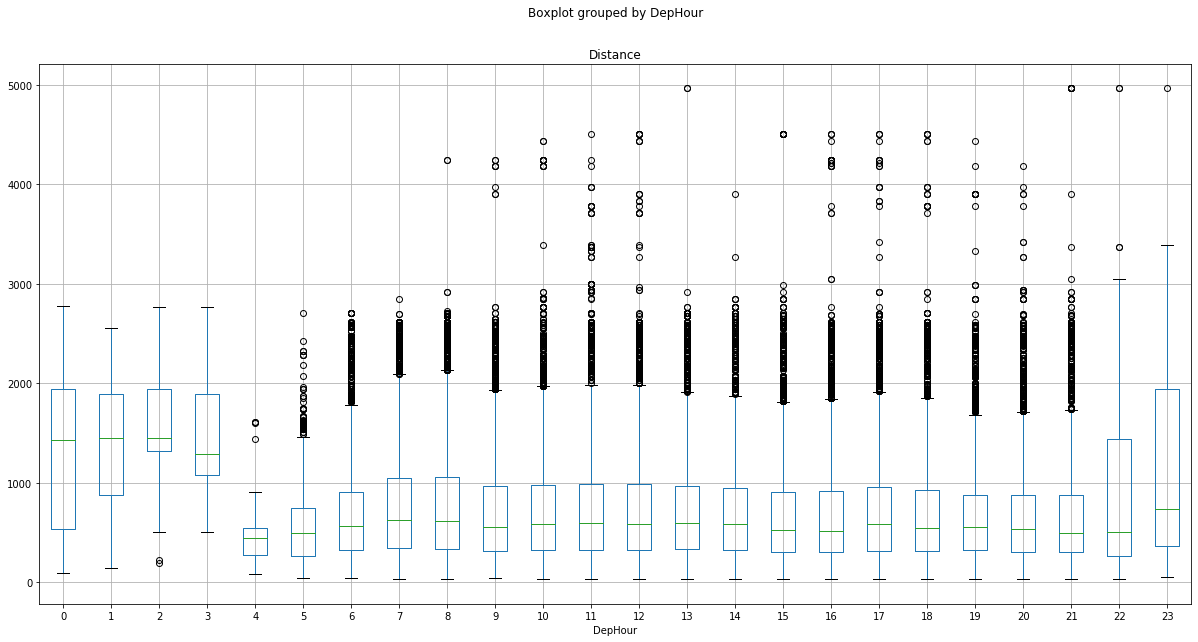

In [22]:
train_df.boxplot(column='Distance', by='DepHour', figsize=(20,10) )

The mean distance travelled per hour is different.The longest flights(by mean) start first thing in the morning.

Text(0.5, 1.0, 'Distance Travelled by Carriers')

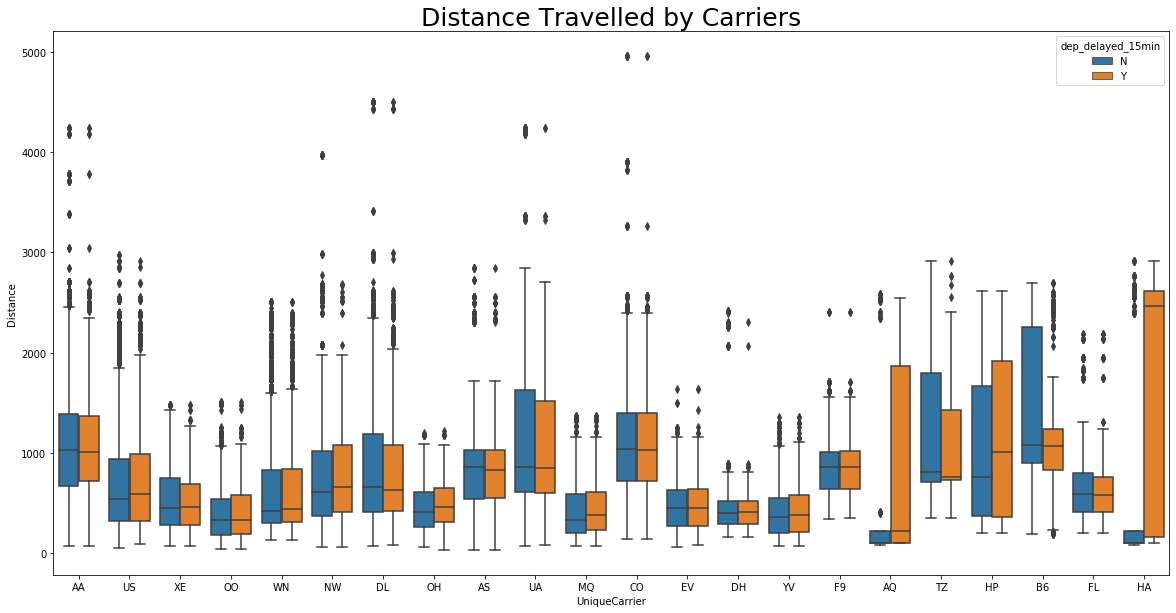

In [23]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x='UniqueCarrier', y = 'Distance', ax = ax, data = train_df,
            hue = 'dep_delayed_15min')
ax.set_title('Distance Travelled by Carriers', size = 25)


We can notice that two carriers have imbalanced proportion of classes. I think, it can mean two things. Either it is the property of these two carriers or we just have such data, that doesn't represent the real world in relations to them 

Text(0.5, 1.0, 'Departure Time by Carriers')

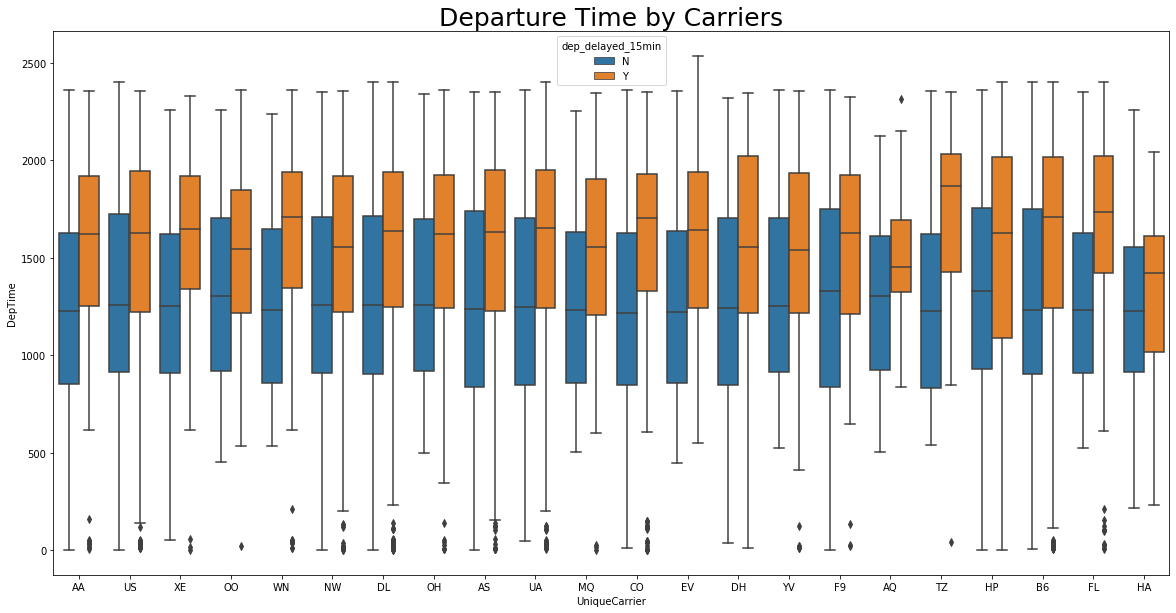

In [24]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x='UniqueCarrier', y = 'DepTime', ax = ax, data = train_df, hue = 'dep_delayed_15min')
ax.set_title('Departure Time by Carriers', size = 25)

The mean time of all the flights which are delayed is later than the flights which are not.

Text(0.5, 1.0, 'Departure Hour by Carriers')

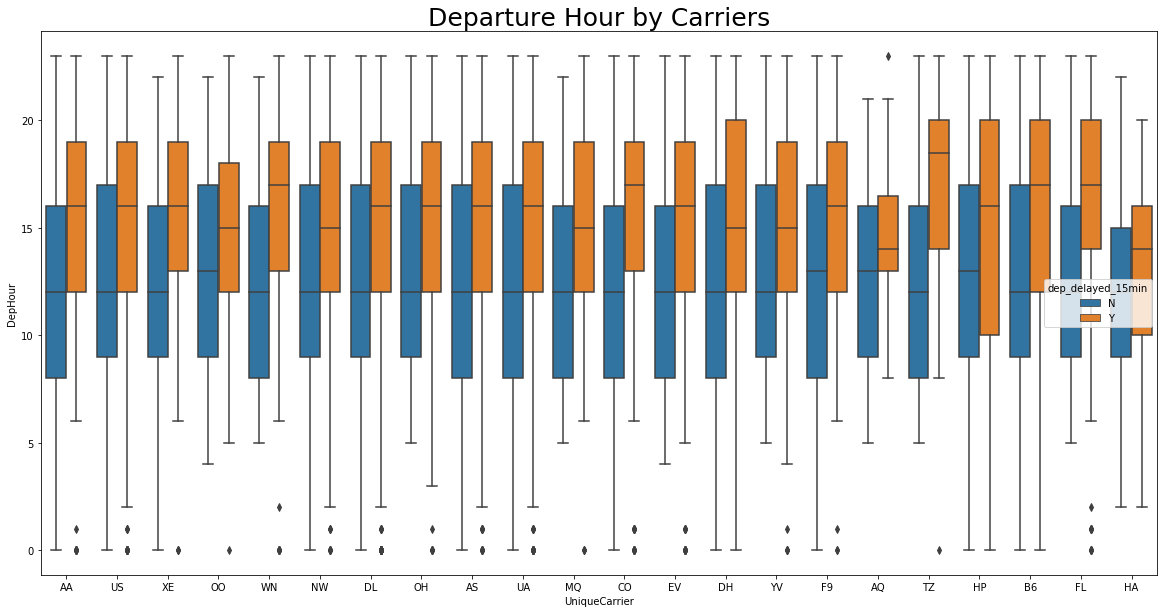

In [25]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x='UniqueCarrier', y ='DepHour', ax = ax, data= train_df, hue = 'dep_delayed_15min')
ax.set_title('Departure Hour by Carriers', size = 25)

Same as the above plot but just the hour component.

In [26]:
# Define a function to create the distribution plots

def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue=target, aspect = 4, row = row, col = col)
    facet.map(sns.kdeplot, var, shade = True)
    facet.set(xlim = (0, df[var].max()))
    facet.add_legend()
    plt.show()

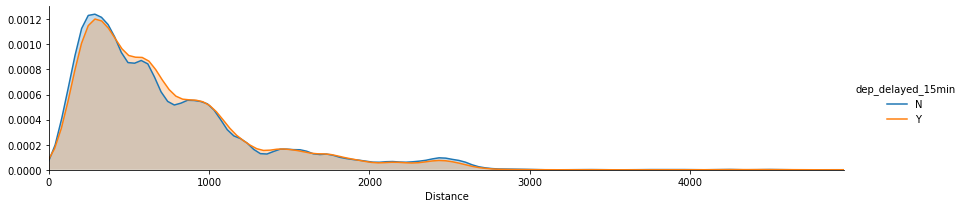

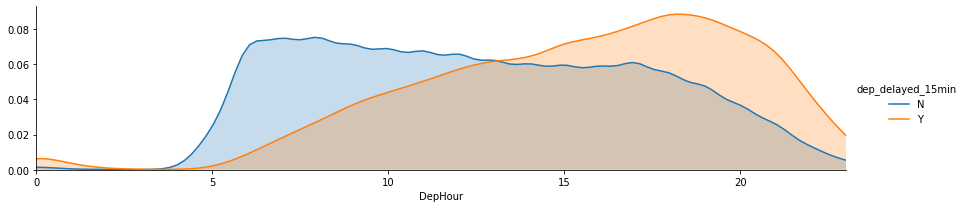

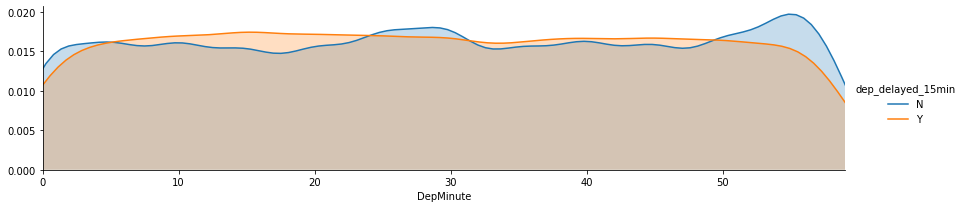

In [27]:
# select numeric columns
num_cols = ['Distance', 'DepHour', 'DepMinute']
for col in num_cols:
    plot_distribution(train_df, col, 'dep_delayed_15min')

Again we observe the difference in hour distribution for delayed and ontime flights

In [28]:
# Using plotly express
px.box(train_df, x = 'Distance', y = 'UniqueCarrier', orientation='h')